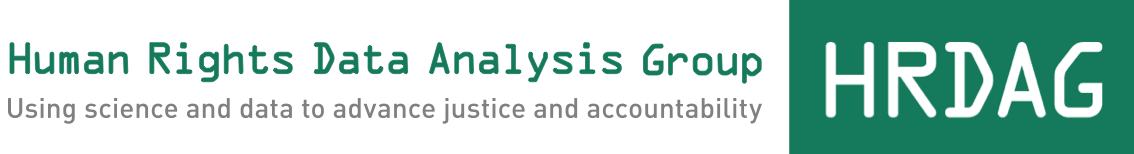

In [1]:
from IPython.display import Image
Image(filename='imgs/banner.png')

In [2]:
%load_ext pretty_jupyter

/Users/home/opt/miniconda3/envs/toolkit/lib/python3.13/site-packages/pretty_jupyter/constants.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [3]:
%%html

<style>
    #Styling {
        font-weight: bold;
        font-family: Helvetica;
    }
</style>

# Recap

In chapter one, we dove into some of the basic data points related to missing persons reports, and how those data points do not always accurately describe the underlying events connected to those reports or the outcomes faced by the humans named in them.

In this chapter we will look closer at the data points related to police procedure and response to missing persons reports. We will compare the expected timeline for police response as informed by CPD directives and state law to what is suggested by the data and by humans who were interviewed as part of the [Chicago Missing Persons Story](chicagomissingpersons.com/).

Our goal was to respond to questions about trends in officer arrival time for the period between 2000-2022 for which we have data. Questions such as:
- Did reported arrival remain the same for the whole period? Did officers take longer to report arrival in later years?
- How are these reports prioritized among other calls for help?

# What happens when a report is made?

Based on research and interviews conducted for the Chicago Missing Persons Story, we've put together the following basic outline of how these reports come to exist, including terminology identified in CPD directives, state law, and other public information, and the resulting data points.

Note that due to the length of the period covered by this analysis, variations of this procedure may have been in place at different points in time. However, we believe this is a reasonably representative outline for the intended process of reporting a missing person. Additionally, during the course of the investigation and research for the main story, we learned that the **"Missing / Found Person" Incident Form** had not been updated since the early 1990s and remained a paper-based report even in 2022.

## Expected timeline

1. Someone (**the “complainant”**) decides to report a missing human (**the "missing"**), either by calling 911 or going in-person to the nearest police station. They provide a `date_last_seen/date_occurred` and `last_known_location/address`, as well as any information they may have about the individual's appearance, habits, etc.
    * **911 calls:** Handled initially by the **Office of Emergency Management & Communication (OEMC)**. If the complainant contacted 911 to make their report, dispatch will assign a priority code to the call, `init_priority`. The priority code is intended to help responding officers prioritize time-sensitive threats and reports involving particularly vulnerable populations such as tender-age children, juveniles, wards of the state, and those who are high risk due to a medical condition or disability.
    * **in-person reports:** Handled by the **Chicago Police Department (CPD)**. If the complainant made the report in-person, the `date_officer_arrived` may be equal to the reported `date_occurred`.
2. Chicago Police accept the report and verify it is a "Bona Fide" report of a missing person before filling out a **"Missing / Found Person" Incident Form** on paper. Each form is assigned a unique "Records Division", or `rd`, number.
3. Chicago Police input the information from the report into databases, **LEADS** and **NCIC**.
4. The paper report is added to the queue at the **Special Victims Unit** to be investigated by the next available detective.
5. When a detective is assigned to the report, they contact the complainant to follow up, go out to the last known location to look for clues, etc.
6. When the police confirm that the missing person has been located, the report and investigation will be updated accordingly. As we showed in the [first chapter](https://hrdag.org/tech-notes/what-is-an-mp-event-nb1-20250721.html), the vast majority of these reports are marked as "Closed Non-Criminal" incidents.

The data lack descriptive information about the circumstances surrounding the disappearance and recovery of missing persons,
so we are unable to study patterns related to these details using the CPD dataset alone.

We can use data like the time between officer arrival and report closure to see if there are trends in how the investigations are closed. For example,

- How similar are the lengths of time until investigation closure? What characteristics were consistent or varying over the period of 20 years?
- Are there signs of cyclical case closures? Is there an interval of time most often associated with these reports?

In [4]:
# dependencies
import re
from datetime import datetime
import pandas as pd
from scipy.stats import ks_2samp, ttest_ind, pearsonr

from plotnine import *

In [5]:
# support methods
def guesstype(ag):
    if pd.isna(ag): return None
    if 'tender age' in ag: return 'MISSTA'
    return 'MISSPE'


def format_count(v):
    return "{:,}".format(v)


def format_float(v, decn=1):
    return round(v, decn)


def format_prop(prop, decn=1, asperc=True):
    if asperc: prop = prop*100
    return "{}%".format(round(prop, decn))


def report_fields(df, idcol, cols, fillval='NO DATA'):
    data = df[[idcol] + cols].drop_duplicates()
    if fillval:
        count = data[cols].fillna(fillval).value_counts().to_frame().reset_index()
        perc = data[cols].fillna(fillval).value_counts(normalize=True).to_frame().reset_index(
            ).rename(columns={'proportion': 'percent'})
    else:
        count = data[cols].value_counts().to_frame().reset_index()
        perc = data[cols].value_counts(normalize=True).to_frame().reset_index(
            ).rename(columns={'proportion': 'percent'})
    count['count'] = count['count'].apply(lambda x: f"{x:,}")
    perc.percent = perc.percent.apply(lambda x: f"{x*100:.2f}%")
    out = pd.merge(count, perc, on=cols)
    return out


def prep_geodata(f):
    geo_df = gpd.read_file(f)
    current_crs = geo_df.crs
    geo_df.to_crs(epsg=3857, inplace=True)
    return geo_df

In [6]:
# primary dataset
basic = ['race', 'sex', 'age', 'age_group', 'address',
         'date_occurred', 'year_occurred',
         'date_officer_arrived', 'notification_time', 'closed_date',
         'status', 'primary', 'description',
         'original_iucr', 'current_iucr',]
mp = pd.read_parquet("../data/cpd_mp.parquet")
mp = mp.loc[mp.year_occurred < 2023].copy()

# supplemental datasets
oemc_disp = pd.read_parquet("../data/oemc_dispatch.parquet")
oemc_loc = pd.read_parquet("../../US-II-MP/individual/OEMC/import/output/oemc_location.parquet")

In [7]:
# formatting MP variables for this analysis
mp['hours_to_arrive'] = mp.time_to_arrive.apply( # date_arrived - date_occurred
    lambda ns: round((ns * 1e-9) / (60 * 60), 1))
mp['days_to_close'] = mp.time_to_close.apply( # closed_date - date_arrived (more options with DTC groups)
    lambda ns: round((ns * 1e-9) / (60 * 60 * 24), 1))
for dtcol in ('closed_date', 'last_update'):
    mp[dtcol] = mp[dtcol].astype('datetime64[ns]')
mp['day_occurred'] = mp.date_occurred.dt.date
mp.address = mp.address.str.replace(", CHICAGO", "")
mp['event_type'] = mp.age_group.apply(guesstype)
mp['closed_day_reported'] = mp.day_occurred == mp.closed_date
mp['closed_day_arrived'] = mp.date_officer_arrived.dt.date == mp.closed_date
mp['est_closed_dt'] = mp.loc[(
    mp.closed_date.notna()) & (
    mp.closed_date == mp.last_update.dt.date),
    'last_update'].dt.strftime('%Y-%m-%d %H:%M')
mp.age_group = mp.age_group.fillna('unknown')
mp['hta_group'] = mp.hours_to_arrive.apply(
    lambda x: 'No arrival' if pd.isna(x) else
    'Under 2' if x < 2 else
    '2-6' if 2 <= x < 6 else
    '6-12' if 6 <= x < 12 else
    '12-24' if 12 <= x < 24 else
    '24-48' if 24 <= x < 48 else
    'Over 48')

# MP indicators
mp['arrival_within_24h'] = mp.hours_to_arrive < 24
mp['arrive_equals_occur'] = mp.date_officer_arrived == mp.date_occurred
mp['arrive_before_occur'] = mp.date_officer_arrived < mp.date_occurred
mp['arrive_equals_close'] = mp.date_officer_arrived.dt.date == mp.closed_date
mp['arrive_after_close'] = mp.date_officer_arrived.dt.date > mp.closed_date

# formatting OEMC data for this analysis
oemc_loc['event_no'] = oemc_loc.event_number.astype(int).astype(str)
oemc_loc.drop(columns='event_number', inplace=True)
oemc_mp = pd.merge(
    oemc_disp, oemc_loc, on='event_no'
)
oemc_mp.entry_date = oemc_mp.entry_date.str.replace(".", ":", regex=False)
oemc_mp.entry_date = oemc_mp.entry_date.astype('datetime64[ns]')
oemc_mp['entry_day'] = oemc_mp.entry_date.dt.date
oemc_mp.location = oemc_mp.location.str.replace(
    "  ", " ").str.replace("\\sAV$", "\\sAVE$")

In [8]:
%%jmd

# Sample records

<details>
<summary>OEMC dispatch for missing persons reports.</summary>

{{ oemc_mp.sample().T.to_html() }}

</details>

<details>
<summary>CPD missing persons reports.</summary>

{{ mp[basic].sample().T.to_html() }}

</details>


# Sample records

<details>
<summary>OEMC dispatch for missing persons reports.</summary>

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>25967</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>event_no</th>
      <td>2014000133</td>
    </tr>
    <tr>
      <th>district</th>
      <td>019</td>
    </tr>
    <tr>
      <th>call_date</th>
      <td>2020-05-19 00:12:00</td>
    </tr>
    <tr>
      <th>disp_date</th>
      <td>2020-05-19 00:13:00</td>
    </tr>
    <tr>
      <th>on_date</th>
      <td>2020-05-19 00:38:00</td>
    </tr>
    <tr>
      <th>clear_date</th>
      <td>2020-05-19 04:17:00</td>
    </tr>
    <tr>
      <th>close_date</th>
      <td>2020-05-19 04:17:00</td>
    </tr>
    <tr>
      <th>init_priority</th>
      <td>2A</td>
    </tr>
    <tr>
      <th>init_type</th>
      <td>MISSING PERSON</td>
    </tr>
    <tr>
      <th>fin_type</th>
      <td>MISSING PERSON</td>
    </tr>
    <tr>
      <th>entry_date</th>
      <td>2020-05-19 00:12:19</td>
    </tr>
    <tr>
      <th>event_type</th>
      <td>MISSPE</td>
    </tr>
    <tr>
      <th>location</th>
      <td>45XX N BEACON ST</td>
    </tr>
    <tr>
      <th>entry_day</th>
      <td>2020-05-19</td>
    </tr>
  </tbody>
</table>

</details>

<details>
<summary>CPD missing persons reports.</summary>

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>340405</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>race</th>
      <td>BLACK</td>
    </tr>
    <tr>
      <th>sex</th>
      <td>M</td>
    </tr>
    <tr>
      <th>age</th>
      <td>29.0</td>
    </tr>
    <tr>
      <th>age_group</th>
      <td>adult (21-59)</td>
    </tr>
    <tr>
      <th>address</th>
      <td>73XX S EXCHANGE AVE</td>
    </tr>
    <tr>
      <th>date_occurred</th>
      <td>2012-11-19 11:00:00</td>
    </tr>
    <tr>
      <th>year_occurred</th>
      <td>2012</td>
    </tr>
    <tr>
      <th>date_officer_arrived</th>
      <td>2012-11-19 21:30:00</td>
    </tr>
    <tr>
      <th>notification_time</th>
      <td>2012-11-19 22:43:00</td>
    </tr>
    <tr>
      <th>closed_date</th>
      <td>2013-01-08 00:00:00</td>
    </tr>
    <tr>
      <th>status</th>
      <td>CLOSED NON-CRIMINAL</td>
    </tr>
    <tr>
      <th>primary</th>
      <td>NON-CRIMINAL</td>
    </tr>
    <tr>
      <th>description</th>
      <td>MISSING PERSON</td>
    </tr>
    <tr>
      <th>original_iucr</th>
      <td>NaN</td>
    </tr>
    <tr>
      <th>current_iucr</th>
      <td>6050</td>
    </tr>
  </tbody>
</table>

</details>

In [9]:
%%jmd

# Sample timelines (using CPD data)

There are {{ format_count(mp.shape[0]) }} reports of a missing person represented in these data. While we generally expect the reported timestamps to appear sequentially, as
1. `date_occurred`,
2. `date_officer_arrived` (may be same as `notification_time`),
3. `closed_date` (may be same as `last_update`),

not all events follow this timeline.


# Sample timelines (using CPD data)

There are 352,911 reports of a missing person represented in these data. While we generally expect the reported timestamps to appear sequentially, as
1. `date_occurred`,
2. `date_officer_arrived` (may be same as `notification_time`),
3. `closed_date` (may be same as `last_update`),

not all events follow this timeline.

In [10]:
arr_equalsoccur = mp.arrive_equals_occur.value_counts(
    ).reset_index().rename(columns={'index': 'arrival_equals_occurred'})
arr_equalsoccur['count'] = arr_equalsoccur['count'].apply(format_count)
arr_equalsclose = mp.arrive_equals_close.value_counts(
    ).reset_index().rename(columns={'index': 'arrival_equals_closure'})
arr_equalsclose['count'] = arr_equalsclose['count'].apply(format_count)
arr_beforeoccur = mp.arrive_before_occur.value_counts(
    ).reset_index().rename(columns={'index': 'arrival_before_occurance'})
arr_beforeoccur['count'] = arr_beforeoccur['count'].apply(format_count)
arr_afterclose = mp.arrive_after_close.value_counts(
    ).reset_index().rename(columns={'index': 'arrival_after_close'})
arr_afterclose['count'] = arr_afterclose['count'].apply(format_count)
sample_arrb4close = mp.loc[mp.date_occurred > mp.date_officer_arrived, [
    'rd_no', 'date_occurred',
    'date_officer_arrived', 'notification_time',
    'closed_date', 'last_update',]
].sample()
sample_arrafter = mp.loc[mp.date_officer_arrived.dt.date > mp.closed_date, [
    'rd_no', 'date_occurred',
    'date_officer_arrived', 'notification_time',
    'closed_date', 'last_update',]
].sample()
ksres = ks_2samp(
    data1=mp.arrive_equals_close.sum(),
    data2=mp.arrive_before_occur.sum(),
) # method='asymp' gets div by 0 warning annd results in nan pvalue even with nan_policy='omit'

In [11]:
%%jmd

## Exceptions

As we have noted above, these reports are originally written on paper and then entered into the database by hand, so we anticipate small numbers of data entry errors from this process. However, while some of the out-of-bounds reports appear only a character or two away from following the expected timeline, multiple explanations are possible. We would want to confirm with underlying reports before applying manual corrections to the data, especially depending on the scale of the potential errors.

**Case 1)** `date_occurred` is exactly the same as `date_officer_arrived`.

From interviews conducted for the [main story](www.chicagomissingpersons.com), this is believed to be an indicator of the complainant making an in-person report.

{{ arr_equalsoccur.to_html() }}

<br>

**Case 2)** `date_officer_arrived` is exactly the same as `closed_date`.

This could happen if by the time the officer reached out to the complainant, the missing person had already been located.

{{ arr_equalsclose.to_html() }}

<br>

**Case 3)** `date_occurred` is _after_ `date_officer_arrived`.

{{ arr_beforeoccur.to_html() }}

<details>
<summary>Sample out-of-bounds occurance and arrival dates.</summary>

{{ sample_arrb4close.T.to_html() }}

</details>

<br>

**Case 4)** `date_officer_arrived` is _after_ `closed_date`.

{{ arr_afterclose.to_html() }}

<details>
<summary>Sample out-of-bounds arrival and closure dates.</summary>

{{ sample_arrafter.T.to_html() }}

</details>

<br>


## Exceptions

As we have noted above, these reports are originally written on paper and then entered into the database by hand, so we anticipate small numbers of data entry errors from this process. However, while some of the out-of-bounds reports appear only a character or two away from following the expected timeline, multiple explanations are possible. We would want to confirm with underlying reports before applying manual corrections to the data, especially depending on the scale of the potential errors.

**Case 1)** `date_occurred` is exactly the same as `date_officer_arrived`.

From interviews conducted for the [main story](www.chicagomissingpersons.com), this is believed to be an indicator of the complainant making an in-person report.

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>arrive_equals_occur</th>
      <th>count</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>False</td>
      <td>341,735</td>
    </tr>
    <tr>
      <th>1</th>
      <td>True</td>
      <td>11,176</td>
    </tr>
  </tbody>
</table>

<br>

**Case 2)** `date_officer_arrived` is exactly the same as `closed_date`.

This could happen if by the time the officer reached out to the complainant, the missing person had already been located.

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>arrive_equals_close</th>
      <th>count</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>False</td>
      <td>341,989</td>
    </tr>
    <tr>
      <th>1</th>
      <td>True</td>
      <td>10,922</td>
    </tr>
  </tbody>
</table>

<br>

**Case 3)** `date_occurred` is _after_ `date_officer_arrived`.

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>arrive_before_occur</th>
      <th>count</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>False</td>
      <td>352,864</td>
    </tr>
    <tr>
      <th>1</th>
      <td>True</td>
      <td>47</td>
    </tr>
  </tbody>
</table>

<details>
<summary>Sample out-of-bounds occurance and arrival dates.</summary>

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>252867</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>rd_no</th>
      <td>JE218548</td>
    </tr>
    <tr>
      <th>date_occurred</th>
      <td>2021-05-02 07:20:00</td>
    </tr>
    <tr>
      <th>date_officer_arrived</th>
      <td>2021-03-03 17:30:00</td>
    </tr>
    <tr>
      <th>notification_time</th>
      <td>2021-05-03 17:42:00</td>
    </tr>
    <tr>
      <th>closed_date</th>
      <td>2021-05-07 00:00:00</td>
    </tr>
    <tr>
      <th>last_update</th>
      <td>2021-05-07 14:20:00</td>
    </tr>
  </tbody>
</table>

</details>

<br>

**Case 4)** `date_officer_arrived` is _after_ `closed_date`.

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>arrive_after_close</th>
      <th>count</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>False</td>
      <td>352,868</td>
    </tr>
    <tr>
      <th>1</th>
      <td>True</td>
      <td>43</td>
    </tr>
  </tbody>
</table>

<details>
<summary>Sample out-of-bounds arrival and closure dates.</summary>

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>337818</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>rd_no</th>
      <td>G454051</td>
    </tr>
    <tr>
      <th>date_occurred</th>
      <td>2001-08-01 16:30:00</td>
    </tr>
    <tr>
      <th>date_officer_arrived</th>
      <td>2001-08-26 19:25:00</td>
    </tr>
    <tr>
      <th>notification_time</th>
      <td>2001-08-01 20:26:00</td>
    </tr>
    <tr>
      <th>closed_date</th>
      <td>2001-08-25 00:00:00</td>
    </tr>
    <tr>
      <th>last_update</th>
      <td>2001-08-25 19:00:00</td>
    </tr>
  </tbody>
</table>

</details>

<br>

In [12]:
# @TODO is this right?? this made sense at the time but I don't think the assumption is fair
inperson = mp.loc[mp.date_occurred == mp.date_officer_arrived].copy()
followup = mp.loc[mp.date_occurred < mp.date_officer_arrived].copy()
oob = mp.loc[mp.date_occurred > mp.date_officer_arrived].copy()
folldesc = followup.hours_to_arrive.describe()
over1day = followup.loc[followup.hours_to_arrive > 24]
folldesc_neat = folldesc.reset_index(
    ).rename(columns={'index': 'statistic'})
for c in folldesc_neat.columns:
    if '_' in c: folldesc_neat[c] = folldesc_neat[c].apply(format_float)

closuredesc = mp.loc[(
    mp.day_occurred < mp.closed_date) & (
    mp.date_officer_arrived < mp.closed_date),
    'days_to_close'].describe()
under30days = mp.loc[mp.days_to_close <= 30]
closuredesc_neat = closuredesc.reset_index(
    ).rename(columns={'index': 'statistic'})
for c in closuredesc_neat.columns:
    if '_' in c: closuredesc_neat[c] = closuredesc_neat[c].apply(format_float)

In [13]:
%%jmd

## Time between occurance and arrival

{{ folldesc_neat.to_html() }}

For the {{ format_count(followup.shape[0]) }} reports that were not originally made in-person, how long did officer arrival typically take?

- 25% have an arrival within {{ format_float(folldesc['25%']) }} hours of the occurrence.
- 50% have an arrival within {{ format_float(folldesc['50%']) }} hours of the occurrence.
- {{ format_count(over1day.shape[0])}} or {{ format_prop(over1day.shape[0]/followup.shape[0], asperc=True) }}
of reports have an arrival more than 24 hours after the date occurred.

## Time between occurance and closure

{{ closuredesc_neat.to_html() }}

{{ report_fields(
    df=mp,
    idcol='rd_no',
    cols=['closed_day_reported', 'closed_day_arrived']
    ).to_html() }}

- 25% of reports were closed within {{ format_float(closuredesc['25%']) }}
    days of the occurrence.
- 50% of reports were closed within {{ format_float(closuredesc['50%']) }}
    days of the occurrence.
- {{ format_count(under30days.shape[0])}} or {{
    format_prop(under30days.shape[0]/mp.shape[0], asperc=True)}}
of reports were closed within 30 days of the date occurred.
- Less than 1% of reports are closed on the same day they are created. About 3% or more than 10,000 reports were closed the same day an officer recorded arrival.


## Time between occurance and arrival

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>statistic</th>
      <th>hours_to_arrive</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>count</td>
      <td>278748.0</td>
    </tr>
    <tr>
      <th>1</th>
      <td>mean</td>
      <td>133.0</td>
    </tr>
    <tr>
      <th>2</th>
      <td>std</td>
      <td>1083.2</td>
    </tr>
    <tr>
      <th>3</th>
      <td>min</td>
      <td>0.0</td>
    </tr>
    <tr>
      <th>4</th>
      <td>25%</td>
      <td>5.5</td>
    </tr>
    <tr>
      <th>5</th>
      <td>50%</td>
      <td>16.3</td>
    </tr>
    <tr>
      <th>6</th>
      <td>75%</td>
      <td>48.8</td>
    </tr>
    <tr>
      <th>7</th>
      <td>max</td>
      <td>122743.3</td>
    </tr>
  </tbody>
</table>

For the 278,748 reports that were not originally made in-person, how long did officer arrival typically take?

- 25% have an arrival within 5.5 hours of the occurrence.
- 50% have an arrival within 16.3 hours of the occurrence.
- 113,033 or 40.6%
of reports have an arrival more than 24 hours after the date occurred.

## Time between occurance and closure

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>statistic</th>
      <th>days_to_close</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>count</td>
      <td>278458.0</td>
    </tr>
    <tr>
      <th>1</th>
      <td>mean</td>
      <td>22.5</td>
    </tr>
    <tr>
      <th>2</th>
      <td>std</td>
      <td>90.1</td>
    </tr>
    <tr>
      <th>3</th>
      <td>min</td>
      <td>0.0</td>
    </tr>
    <tr>
      <th>4</th>
      <td>25%</td>
      <td>6.6</td>
    </tr>
    <tr>
      <th>5</th>
      <td>50%</td>
      <td>10.4</td>
    </tr>
    <tr>
      <th>6</th>
      <td>75%</td>
      <td>19.2</td>
    </tr>
    <tr>
      <th>7</th>
      <td>max</td>
      <td>6167.2</td>
    </tr>
  </tbody>
</table>

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>closed_day_reported</th>
      <th>closed_day_arrived</th>
      <th>count</th>
      <th>percent</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>False</td>
      <td>False</td>
      <td>341,921</td>
      <td>96.89%</td>
    </tr>
    <tr>
      <th>1</th>
      <td>False</td>
      <td>True</td>
      <td>10,630</td>
      <td>3.01%</td>
    </tr>
    <tr>
      <th>2</th>
      <td>True</td>
      <td>True</td>
      <td>292</td>
      <td>0.08%</td>
    </tr>
    <tr>
      <th>3</th>
      <td>True</td>
      <td>False</td>
      <td>68</td>
      <td>0.02%</td>
    </tr>
  </tbody>
</table>

- 25% of reports were closed within 6.6
    days of the occurrence.
- 50% of reports were closed within 10.4
    days of the occurrence.
- 249,946 or 70.8%
of reports were closed within 30 days of the date occurred.
- Less than 1% of reports are closed on the same day they are created. About 3% or more than 10,000 reports were closed the same day an officer recorded arrival.

In [14]:
arrbyage = mp.loc[mp.date_occurred < mp.date_officer_arrived, ['age_group', 'hours_to_arrive']].dropna()
aba_table = arrbyage.groupby('age_group').hours_to_arrive.describe(percentiles=[.25, .5, .75, .95])
aba_table.drop(columns=['min', 'max'], inplace=True)
aba_table['count'] = aba_table['count'].astype(int)
for col in ('mean', 'std', '95%'): aba_table[col] = aba_table[col].apply(format_float)
aba_table = aba_table.reindex(['tender age (0-9)', 'youth (10-20)', 'adult (21-59)', 'elder (60+)'])

In [15]:
arrt = mp.loc[mp.arrival_within_24h, 'age_group'].value_counts(
    ).reset_index().rename(columns={'count': 'arrival_within_24h'})
arrf = mp.loc[~(mp.arrival_within_24h) & (mp.date_officer_arrived.notna()), 'age_group'].value_counts(
    ).reset_index().rename(columns={'count': 'after_24h'})
arrn = mp.loc[mp.date_officer_arrived.isna(), 'age_group'].value_counts(
    ).reset_index().rename(columns={'count': 'no_data'})
n_noarrival = mp.loc[~mp.arrival_within_24h, 'date_officer_arrived'].isna().sum()
aba_excess_table = pd.merge(arrt, arrf, on='age_group')
aba_excess_table = pd.merge(aba_excess_table, arrn, on='age_group')
aba_excess_table['total'] = aba_excess_table[[c for c in aba_excess_table.columns
    if c != 'age_group']].apply(lambda row: sum(row.values), axis=1)
for col in aba_excess_table.columns:
    if col != 'age_group': aba_excess_table[col] = aba_excess_table[col].apply(format_count)
agindex = ['tender age (0-9)', 'youth (10-20)', 'adult (21-59)', 'elder (60+)', 'unknown']
aba_excess_table = aba_excess_table.set_index('age_group').reindex(agindex).reset_index()

In [16]:
%%jmd

### Number of hours to arrive, by age group

**Overall statistics**

{{ aba_table.reset_index().to_html() }}

- Most reports of tender age and elder missings have an arrival within 12 hours.
- Most reports of an adult missing have an arrival after 24 hours.


### Number of hours to arrive, by age group

**Overall statistics**

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>age_group</th>
      <th>count</th>
      <th>mean</th>
      <th>std</th>
      <th>25%</th>
      <th>50%</th>
      <th>75%</th>
      <th>95%</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>tender age (0-9)</td>
      <td>8240</td>
      <td>136.9</td>
      <td>988.3</td>
      <td>3.5</td>
      <td>11.5</td>
      <td>52.8</td>
      <td>454.6</td>
    </tr>
    <tr>
      <th>1</th>
      <td>youth (10-20)</td>
      <td>209066</td>
      <td>103.3</td>
      <td>835.2</td>
      <td>5.2</td>
      <td>15.4</td>
      <td>41.2</td>
      <td>339.3</td>
    </tr>
    <tr>
      <th>2</th>
      <td>adult (21-59)</td>
      <td>48648</td>
      <td>231.1</td>
      <td>1557.4</td>
      <td>9.0</td>
      <td>26.7</td>
      <td>90.0</td>
      <td>677.4</td>
    </tr>
    <tr>
      <th>3</th>
      <td>elder (60+)</td>
      <td>11740</td>
      <td>249.0</td>
      <td>2135.2</td>
      <td>3.9</td>
      <td>10.6</td>
      <td>40.0</td>
      <td>504.4</td>
    </tr>
  </tbody>
</table>

- Most reports of tender age and elder missings have an arrival within 12 hours.
- Most reports of an adult missing have an arrival after 24 hours.

In [17]:
%%jmd

### Reports and whether arrival was within 24 hours, by age group

{{ aba_excess_table.to_html() }}

- All known age groups have at least a couple thousand reports with an arrival reported later than 24 hours and some number of reports without any reported arrival date in these data.
- More than 40% of reported tender age missing children have an officer arrival after 24 hours or none at all. The same is true for youth missings and elders.


### Reports and whether arrival was within 24 hours, by age group

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>age_group</th>
      <th>arrival_within_24h</th>
      <th>after_24h</th>
      <th>no_data</th>
      <th>total</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>tender age (0-9)</td>
      <td>5,734</td>
      <td>2,937</td>
      <td>1,238</td>
      <td>9,909</td>
    </tr>
    <tr>
      <th>1</th>
      <td>youth (10-20)</td>
      <td>137,394</td>
      <td>80,165</td>
      <td>42,209</td>
      <td>259,768</td>
    </tr>
    <tr>
      <th>2</th>
      <td>adult (21-59)</td>
      <td>23,961</td>
      <td>26,434</td>
      <td>15,365</td>
      <td>65,760</td>
    </tr>
    <tr>
      <th>3</th>
      <td>elder (60+)</td>
      <td>8,158</td>
      <td>4,025</td>
      <td>3,722</td>
      <td>15,905</td>
    </tr>
    <tr>
      <th>4</th>
      <td>unknown</td>
      <td>820</td>
      <td>343</td>
      <td>406</td>
      <td>1,569</td>
    </tr>
  </tbody>
</table>

- All known age groups have at least a couple thousand reports with an arrival reported later than 24 hours and some number of reports without any reported arrival date in these data.
- More than 40% of reported tender age missing children have an officer arrival after 24 hours or none at all. The same is true for youth missings and elders.

In [18]:
dates = pd.date_range(mp.date_occurred.min(), mp.date_occurred.max())
#dailys = []
#active = 0
#for date in dates:
#    day = date.date()
#    new = (mp.day_occurred == day).sum()
#    closed = (mp.closed_date.dt.date == day).sum()
#    info = {
#        'date': date,
#        'n_open': active,
#        'n_new': new,
#        'n_closed': closed
#    }
#    dailys.append(info)
#    active = active + new - closed
#df = pd.DataFrame(dailys)
#df.date = df.date.date.astype('datetime64[ns]')
#df.to_csv("../data/mp_daily_counts.csv", index=False)
df = pd.read_csv("../data/mp_daily_counts.csv")
df.date = df.date.astype('datetime64[ns]')

assert mp.shape[0] == df.n_new.sum()
assert (df.n_new.sum() - df.n_closed.sum()) == (
    df.n_open.values[-1] + df.n_new.values[-1] - df.n_closed.values[-1])
assert not (df.n_new == 0).any()

df['none_closed'] = df.n_closed == 0
df['more_closed'] = df.n_new < df.n_closed
df['7day_avg_new'] = df.n_new.rolling(window=7).mean()
df['7day_avg_close'] = df.n_closed.rolling(window=7).mean()
df['30day_avg_new'] = df.n_new.rolling(window=30).mean()
df['30day_avg_close'] = df.n_closed.rolling(window=30).mean()

melted = pd.melt(
    df,
    id_vars=['date'],
    value_vars=[
        'n_new', 'n_open', 'n_closed',
        '7day_avg_new', '7day_avg_close',
        '30day_avg_new', '30day_avg_close',
    ],
    value_name='count',
    var_name='count type'
)

In [19]:
new_closed_desc = pd.merge(
    df.n_new.describe().reset_index(),
    df.n_closed.describe().reset_index()
    )
for c in new_closed_desc.columns:
    if '_' in c: new_closed_desc[c] = new_closed_desc[c].apply(format_float)
new_closed_desc.rename(columns={'index': 'statistic'}, inplace=True)

new_closed_7daydesc = pd.merge(
    df['7day_avg_new'].describe().reset_index(),
    df['7day_avg_close'].describe().reset_index()
    )
for c in new_closed_7daydesc.columns:
    if '_' in c: new_closed_7daydesc[c] = new_closed_7daydesc[c].apply(format_float)

n_closed_diffday = mp.est_closed_dt.isna().sum()
closed_permin = mp[['rd_no', 'est_closed_dt']].groupby('est_closed_dt').nunique(
    ).rename(columns={'rd_no': 'n_closed'})
excess_1permin = closed_permin[closed_permin.n_closed > 1].reset_index()
excess_5permin = closed_permin[closed_permin.n_closed > 5].reset_index()
nearly_1permin = round(excess_1permin.shape[0], -4)
nearly_5permin = round(excess_5permin.shape[0], -3)
tenworst = excess_1permin.sort_values(
    'n_closed', ascending=False).reset_index(drop=True).head(10)

In [20]:
%%jmd

# Daily case counts

CPD has faced allegations of premature case closure and inappropriate outcome classification, including in the [main story](chicagomissingpersons.com) through examples of reports of missing persons who became the victim of a homicide or are still missing that have been closed with the label "incident not criminal in nature." We know that this label is not representative of the "ground truth" of what happened to a missing person, but we continue to explore possible explanations for how it's assigned and the nature of how case closures are handled through analysis on the time between when cases are reported and closed.

If the number of active cases on a given day can be understood as the investigating unit's "workload", how does the trend in workload compare to the trend in cases closed? Are these two trends independent?

- `n_new`: number of new cases reported on a given day.
- `n_closed`: number of cases closed on a given day.

{{ new_closed_desc.to_html() }}

While the `closed_date` values provided by CPD do not include the hour and minute of closure, the day of the last update and the closed date are the same for the vast majority of reports, so we can use the `last_update` timestamp as the exact moment of case closure for all such reports.

We find nearly {{ format_count(nearly_1permin) }} examples of multiple reports being closed simultaneously, of which almost {{ format_count(nearly_5permin) }} examples show more than 5 reports closed at the same time. A total of {{ format_count(excess_1permin.n_closed.sum()) }} missing persons reports were closed simultaneously with at least one other report.

Here are ten timestamps with the highest counts of cases closed:

{{ tenworst.to_html() }}

Given that case closure should be accompanied by a written update or even an additional report documenting the justification for doing so, we did not expect to see so many examples of bulk case closures.

<details>
<summary>Sample daily counts.</summary>

{{ df.sample().T.to_html() }}

</details>


# Daily case counts

CPD has faced allegations of premature case closure and inappropriate outcome classification, including in the [main story](chicagomissingpersons.com) through examples of reports of missing persons who became the victim of a homicide or are still missing that have been closed with the label "incident not criminal in nature." We know that this label is not representative of the "ground truth" of what happened to a missing person, but we continue to explore possible explanations for how it's assigned and the nature of how case closures are handled through analysis on the time between when cases are reported and closed.

If the number of active cases on a given day can be understood as the investigating unit's "workload", how does the trend in workload compare to the trend in cases closed? Are these two trends independent?

- `n_new`: number of new cases reported on a given day.
- `n_closed`: number of cases closed on a given day.

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>statistic</th>
      <th>n_new</th>
      <th>n_closed</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>count</td>
      <td>8401.0</td>
      <td>8401.0</td>
    </tr>
    <tr>
      <th>1</th>
      <td>mean</td>
      <td>42.0</td>
      <td>41.8</td>
    </tr>
    <tr>
      <th>2</th>
      <td>std</td>
      <td>17.0</td>
      <td>28.0</td>
    </tr>
    <tr>
      <th>3</th>
      <td>min</td>
      <td>7.0</td>
      <td>0.0</td>
    </tr>
    <tr>
      <th>4</th>
      <td>25%</td>
      <td>29.0</td>
      <td>20.0</td>
    </tr>
    <tr>
      <th>5</th>
      <td>50%</td>
      <td>40.0</td>
      <td>38.0</td>
    </tr>
    <tr>
      <th>6</th>
      <td>75%</td>
      <td>53.0</td>
      <td>59.0</td>
    </tr>
    <tr>
      <th>7</th>
      <td>max</td>
      <td>130.0</td>
      <td>225.0</td>
    </tr>
  </tbody>
</table>

While the `closed_date` values provided by CPD do not include the hour and minute of closure, the day of the last update and the closed date are the same for the vast majority of reports, so we can use the `last_update` timestamp as the exact moment of case closure for all such reports.

We find nearly 70,000 examples of multiple reports being closed simultaneously, of which almost 8,000 examples show more than 5 reports closed at the same time. A total of 234,937 missing persons reports were closed simultaneously with at least one other report.

Here are ten timestamps with the highest counts of cases closed:

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>est_closed_dt</th>
      <th>n_closed</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>2010-05-19 11:19</td>
      <td>64</td>
    </tr>
    <tr>
      <th>1</th>
      <td>2015-05-09 18:07</td>
      <td>63</td>
    </tr>
    <tr>
      <th>2</th>
      <td>2010-05-29 18:08</td>
      <td>51</td>
    </tr>
    <tr>
      <th>3</th>
      <td>2014-11-04 18:33</td>
      <td>50</td>
    </tr>
    <tr>
      <th>4</th>
      <td>2008-08-30 16:57</td>
      <td>50</td>
    </tr>
    <tr>
      <th>5</th>
      <td>2010-02-21 14:25</td>
      <td>48</td>
    </tr>
    <tr>
      <th>6</th>
      <td>2007-07-27 14:28</td>
      <td>45</td>
    </tr>
    <tr>
      <th>7</th>
      <td>2010-11-15 12:04</td>
      <td>44</td>
    </tr>
    <tr>
      <th>8</th>
      <td>2011-01-02 13:15</td>
      <td>44</td>
    </tr>
    <tr>
      <th>9</th>
      <td>2008-10-18 10:23</td>
      <td>43</td>
    </tr>
  </tbody>
</table>

Given that case closure should be accompanied by a written update or even an additional report documenting the justification for doing so, we did not expect to see so many examples of bulk case closures.

<details>
<summary>Sample daily counts.</summary>

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>8205</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>date</th>
      <td>2022-06-19 00:00:00</td>
    </tr>
    <tr>
      <th>n_open</th>
      <td>1394</td>
    </tr>
    <tr>
      <th>n_new</th>
      <td>30</td>
    </tr>
    <tr>
      <th>n_closed</th>
      <td>2</td>
    </tr>
    <tr>
      <th>none_closed</th>
      <td>False</td>
    </tr>
    <tr>
      <th>more_closed</th>
      <td>False</td>
    </tr>
    <tr>
      <th>7day_avg_new</th>
      <td>27.571429</td>
    </tr>
    <tr>
      <th>7day_avg_close</th>
      <td>25.714286</td>
    </tr>
    <tr>
      <th>30day_avg_new</th>
      <td>24.7</td>
    </tr>
    <tr>
      <th>30day_avg_close</th>
      <td>27.666667</td>
    </tr>
  </tbody>
</table>

</details>

Next, we continue to explore the relationship between the new and closed daily case totals.

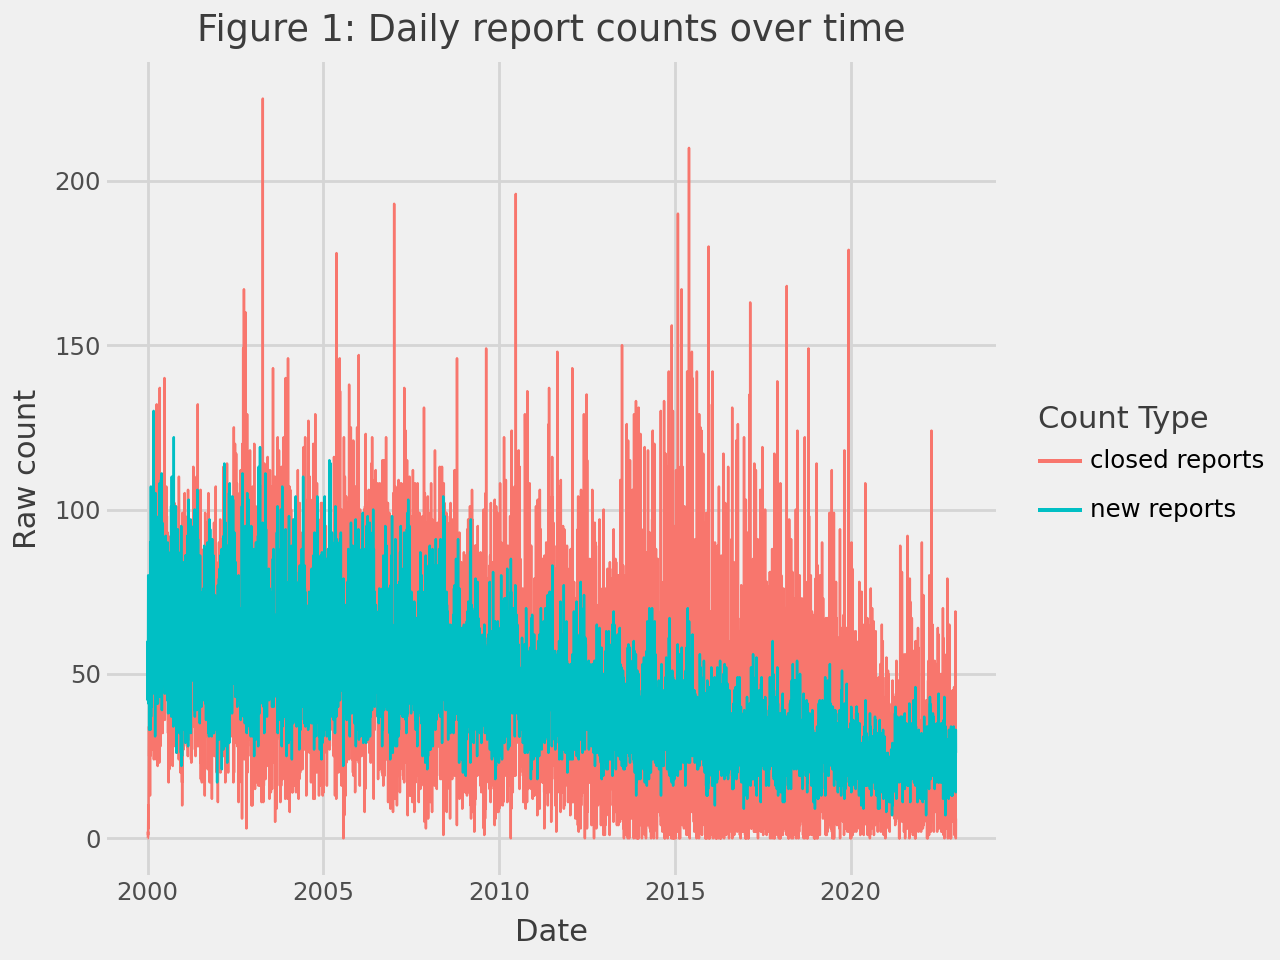

In [21]:
data = melted.loc[melted['count type'].str.contains(
    'n_new|n_closed')].dropna().copy()
data['count type'] = data['count type'].replace({
    'n_new': 'new reports', 'n_closed': 'closed reports'})
data.rename(columns={'count type': 'Count Type'}, inplace=True)

(
    ggplot(
        data,
        aes(x="date", y="count", color="Count Type"))
    + geom_line()
    + scale_x_datetime(date_breaks="5 years", date_labels="%Y")
    + scale_y_continuous()
    + theme_538()
    + labs(
        title='Figure 1: Daily report counts over time',
        x='Date',
        y='Raw count')
)

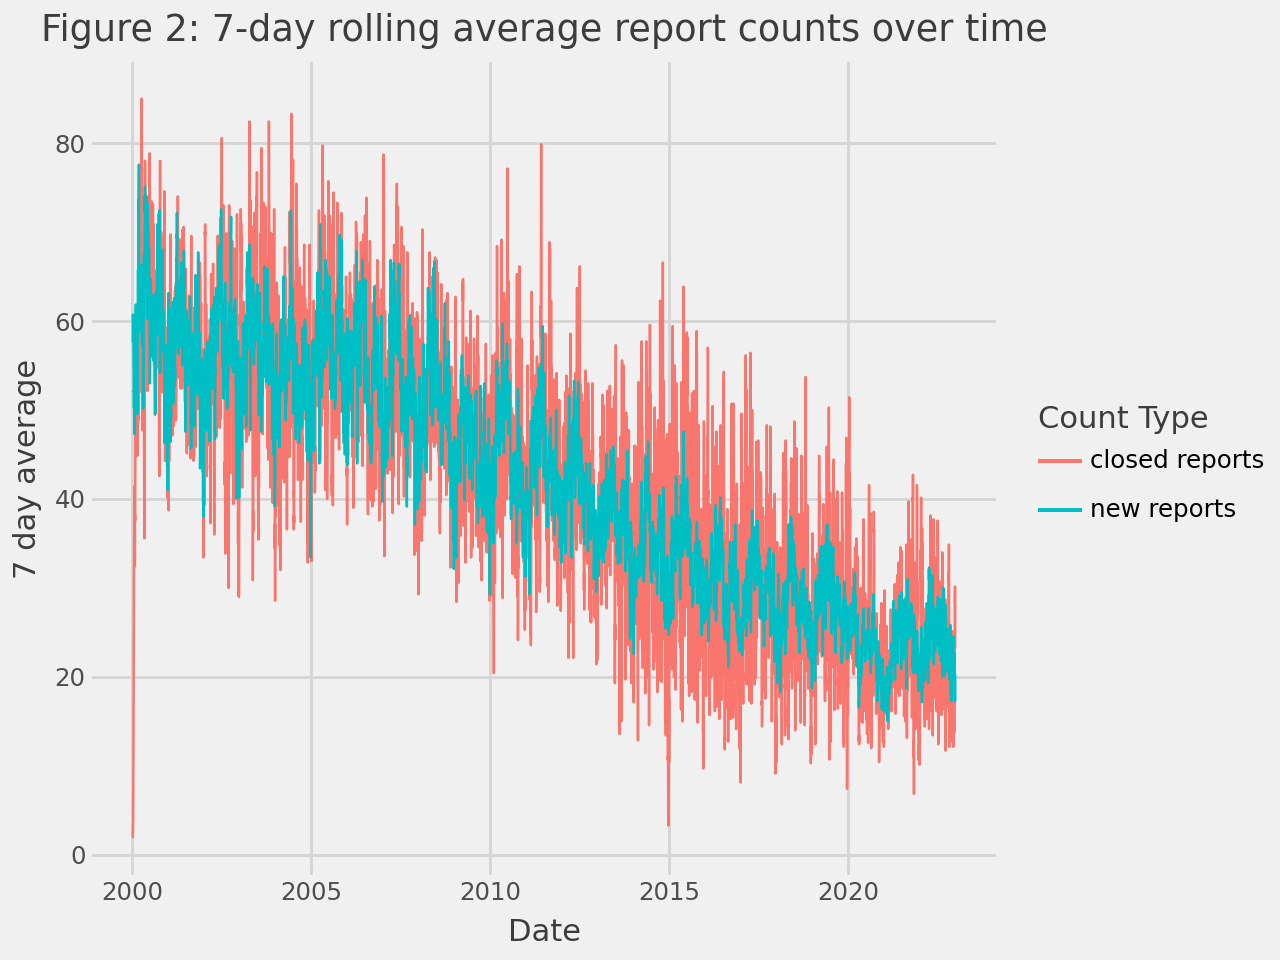

In [22]:
data = melted.loc[melted['count type'].str.contains(
    '7day_avg_new|7day_avg_close')].dropna().copy()
data['count type'] = data['count type'].replace({
    '7day_avg_new': 'new reports', '7day_avg_close': 'closed reports'})
data.rename(columns={'count type': 'Count Type'}, inplace=True)

(
    ggplot(
        data,
        aes(x="date", y="count", color="Count Type"))
    + geom_line()
    + scale_x_datetime(date_breaks="5 years", date_labels="%Y")
    + scale_y_continuous()
    + theme_538()
    + labs(
        title='Figure 2: 7-day rolling average report counts over time',
        x='Date',
        y='7 day average')
)

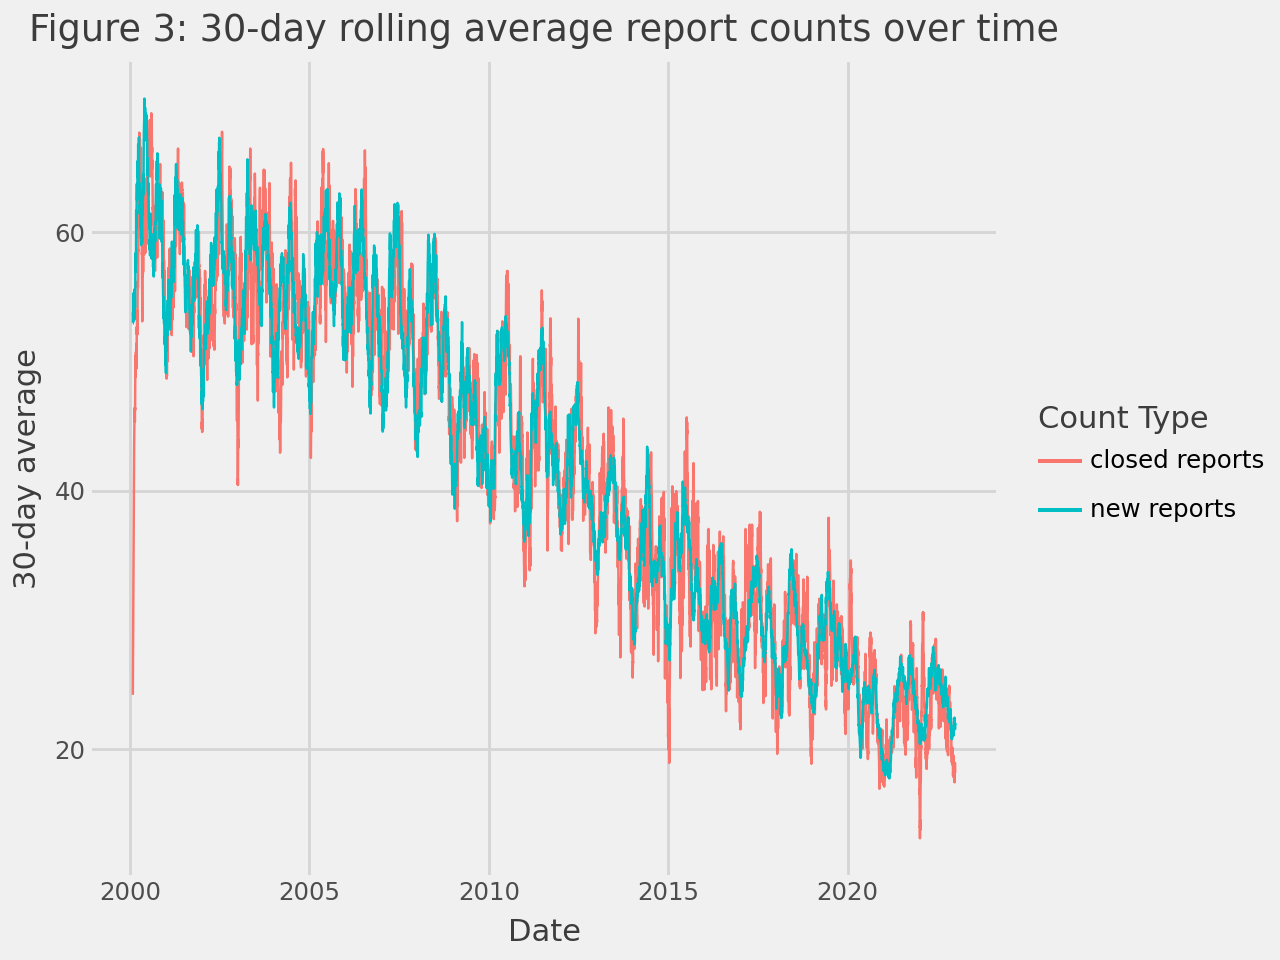

In [23]:
data = melted.loc[melted['count type'].str.contains(
    '30day_avg_new|30day_avg_close')].dropna().copy()
data['count type'] = data['count type'].replace({
    '30day_avg_new': 'new reports', '30day_avg_close': 'closed reports'})
data.rename(columns={'count type': 'Count Type'}, inplace=True)

(
    ggplot(
        data,
        aes(x="date", y="count", color="Count Type"))
    + geom_line()
    + scale_x_datetime(date_breaks="5 years", date_labels="%Y")
    + scale_y_continuous()
    + theme_538()
    + labs(
        title='Figure 3: 30-day rolling average report counts over time',
        x='Date',
        y='30-day average')
)

In [24]:
nday = 7
newcounts = melted.loc[melted['count type'].str.contains(
    f'{nday}day_avg_new'), 'count'].fillna(0).values
closecounts = melted.loc[melted['count type'].str.contains(
    f'{nday}day_avg_close'), 'count'].fillna(0).values

# independent samples t-test
ttest_res = ttest_ind(newcounts, closecounts)
fail_info = f"An independent samples t-test on the {nday}-day averages results in a failure to reject the null hypothesis that the means of the distributions underlying the samples are equal. In other words, there is not enough evidence to conclude that there is a significant difference between the number of new assigned reports per day and closed cases per day."
reject_info = f"An independent samples t-test on the {nday}-day averages results in rejecting the null hypothesis that the means of the distributions underlying the samples are equal. In other words, there is enough evidence to conclude that there is a significant difference between the number of new assigned reports per day and closed cases per day."
conf = f"The confidence interval, or the range of values within which \
the difference between the means of the two populations may lie, is {
format_float(ttest_res.confidence_interval().low)} to {
format_float(ttest_res.confidence_interval().high)}."

# pearson correlation test
corr_res = pearsonr(newcounts, closecounts)
pos_info = f"A Pearson Correlation test on the {nday}-day averages results in \
a test statistic of {format_float(corr_res.statistic)}, which indicates \
a positive relationship between the two sets of numbers. In other words, \
there is a direct relationship between the number of daily new and closed reports."
neg_info = f"A Pearson Correlation test on the {nday}-day averages results in \
a test statistic of {format_float(corr_res.statistic)}, which indicates \
a negative relationship between the two sets of numbers. In other words, \
there is an inverse relationship between the number of daily new and closed reports."
none_info = f"A Pearson Correlation test on the {nday}-day averages results in \
a test statistic of {format_float(corr_res.statistic)}, which indicates \
no relationship between the two sets of numbers."

In [25]:
%%jmd

In Figures 1-3, we consider the actual daily totals alongside 7- and 30-day rolling averages to test different levels of noise reduction. The result appears to be a consolidation of the two trend lines into one.

Consider a couple scenarios that could influence the nature of the relationship between these variables:
- Direct correlation
    - When new reports increase the workload beyond some capacity, new resources and/or pressure may be allocated to the investigating unit to close cases. This could look like an increase in new reports followed by an increase in closures.
    - When premature case closures occur and complainants follow up, cases may be re-opened or documented as a new report. This could look like an increase in closures followed by an increase in new reports.
- Inverse correlation
    - When fewer new reports come in, the investigating unit can focus on follow up calls and closing cases. This could look like a decrease in new reports followed by an increase in closed cases.

We conduct two additional tests to elaborate on this relationship further.

{{ reject_info if ttest_res.pvalue < 0.05 else fail_info }} {{ conf }}

{{ pos_info if corr_res.statistic > 0.5 else (
    neg_info if corr_res.statistic < -0.5 else none_info) }}

We have observed:
- a consistent overlap between these two types of daily case totals in Figure 3 for the whole 20+ year period,
- a strong positive correlation between the two variables,
- a lack of evidence to conclude that there is a significant difference between the means of the distributions underlying the number of new assigned calls per day and closed cases per day.


In Figures 1-3, we consider the actual daily totals alongside 7- and 30-day rolling averages to test different levels of noise reduction. The result appears to be a consolidation of the two trend lines into one.

Consider a couple scenarios that could influence the nature of the relationship between these variables:
- Direct correlation
    - When new reports increase the workload beyond some capacity, new resources and/or pressure may be allocated to the investigating unit to close cases. This could look like an increase in new reports followed by an increase in closures.
    - When premature case closures occur and complainants follow up, cases may be re-opened or documented as a new report. This could look like an increase in closures followed by an increase in new reports.
- Inverse correlation
    - When fewer new reports come in, the investigating unit can focus on follow up calls and closing cases. This could look like a decrease in new reports followed by an increase in closed cases.

We conduct two additional tests to elaborate on this relationship further.

An independent samples t-test on the 7-day averages results in a failure to reject the null hypothesis that the means of the distributions underlying the samples are equal. In other words, there is not enough evidence to conclude that there is a significant difference between the number of new assigned reports per day and closed cases per day. The confidence interval, or the range of values within which the difference between the means of the two populations may lie, is -0.2 to 0.6.

A Pearson Correlation test on the 7-day averages results in a test statistic of 0.8, which indicates a positive relationship between the two sets of numbers. In other words, there is a direct relationship between the number of daily new and closed reports.

We have observed:
- a consistent overlap between these two types of daily case totals in Figure 3 for the whole 20+ year period,
- a strong positive correlation between the two variables,
- a lack of evidence to conclude that there is a significant difference between the means of the distributions underlying the number of new assigned calls per day and closed cases per day.

---

In [26]:
possible_oemc = oemc_mp.loc[(
    oemc_mp.entry_day.isin(mp.day_occurred)) & (
    oemc_mp.location.isin(mp.address)), [
    'event_no', 'entry_day', 'location', 'event_type', 'init_priority']
    ].copy().reset_index(drop=True).rename(columns={
    'entry_day': 'day_occurred', 'location': 'address'})
mp['possible'] = (
    mp.day_occurred.isin(oemc_mp.entry_day)) & (
    mp.address.isin(oemc_mp.location))
possible_mp = mp.loc[mp.possible, [
    'rd_no', 'day_occurred', 'address', 'event_type', 'age_group',]
    ].reset_index(drop=True).copy()

possible = pd.merge(
    possible_oemc,
    possible_mp,
    on=['day_occurred', 'address', 'event_type']
)

In [27]:
%%jmd

# Record linkage

These missing persons data do not include the OEMC `event_no`, so we search for approximate or candidate matches between the {{ format_count(oemc_mp.shape[0]) }} OEMC and {{ format_count(mp.shape[0]) }} CPD records referring to missing persons to analyze the timeline of the reports originating as emergency calls. Note that the OEMC records cover 2018 thru 2021, so any matches to CPD data should also be in that period.

We identify candidate matches using the date, location, and approximate age data associated with each record. While we don't have precise age data in the OEMC records, we do have the call type, which we can use to distinguish tender age missing persons ('MISSTA') from other age groups ('MISSPE') for the purposes of refining the candidate matches. We translate the age group data in the CPD records down to the expected OEMC event type to support this comparison, in addition to performing some standardization to the date and location data and filtering out calls about missing persons who have returned home ('MISSR').

{{ report_fields(
    df=oemc_mp,
    idcol='event_no',
    cols=['event_type',]).to_html() }}

<details>
<summary>Sample approximate or candidate record.</summary>

{{ possible.head().to_html() }}

</details>


# Record linkage

These missing persons data do not include the OEMC `event_no`, so we search for approximate or candidate matches between the 42,951 OEMC and 352,911 CPD records referring to missing persons to analyze the timeline of the reports originating as emergency calls. Note that the OEMC records cover 2018 thru 2021, so any matches to CPD data should also be in that period.

We identify candidate matches using the date, location, and approximate age data associated with each record. While we don't have precise age data in the OEMC records, we do have the call type, which we can use to distinguish tender age missing persons ('MISSTA') from other age groups ('MISSPE') for the purposes of refining the candidate matches. We translate the age group data in the CPD records down to the expected OEMC event type to support this comparison, in addition to performing some standardization to the date and location data and filtering out calls about missing persons who have returned home ('MISSR').

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>event_type</th>
      <th>count</th>
      <th>percent</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>MISSPE</td>
      <td>39,280</td>
      <td>91.45%</td>
    </tr>
    <tr>
      <th>1</th>
      <td>MISSTA</td>
      <td>3,374</td>
      <td>7.86%</td>
    </tr>
    <tr>
      <th>2</th>
      <td>MISSR</td>
      <td>297</td>
      <td>0.69%</td>
    </tr>
  </tbody>
</table>

<details>
<summary>Sample approximate or candidate record.</summary>

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>event_no</th>
      <th>day_occurred</th>
      <th>address</th>
      <th>event_type</th>
      <th>init_priority</th>
      <th>rd_no</th>
      <th>age_group</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>1809104049</td>
      <td>2018-04-01</td>
      <td>36XX W FILLMORE ST</td>
      <td>MISSPE</td>
      <td>3C</td>
      <td>JB207332</td>
      <td>youth (10-20)</td>
    </tr>
    <tr>
      <th>1</th>
      <td>1809104049</td>
      <td>2018-04-01</td>
      <td>36XX W FILLMORE ST</td>
      <td>MISSPE</td>
      <td>3C</td>
      <td>JB207953</td>
      <td>youth (10-20)</td>
    </tr>
    <tr>
      <th>2</th>
      <td>1809109693</td>
      <td>2018-04-01</td>
      <td>71XX S GREEN ST</td>
      <td>MISSPE</td>
      <td>1A</td>
      <td>JB207752</td>
      <td>youth (10-20)</td>
    </tr>
    <tr>
      <th>3</th>
      <td>1809112618</td>
      <td>2018-04-01</td>
      <td>36XX W FILLMORE ST</td>
      <td>MISSPE</td>
      <td>3C</td>
      <td>JB207332</td>
      <td>youth (10-20)</td>
    </tr>
    <tr>
      <th>4</th>
      <td>1809112618</td>
      <td>2018-04-01</td>
      <td>36XX W FILLMORE ST</td>
      <td>MISSPE</td>
      <td>3C</td>
      <td>JB207953</td>
      <td>youth (10-20)</td>
    </tr>
  </tbody>
</table>

</details>

In [28]:
rds_perevent = possible.groupby('event_no').rd_no.nunique().reset_index().rename(columns={'rd_no': 'n_rds'})
vc = rds_perevent.n_rds.value_counts().sort_index().reset_index()
onematch = rds_perevent.loc[rds_perevent.n_rds == 1, 'event_no'].unique()
onematch = possible.loc[possible.event_no.isin(onematch)].reset_index(drop=True)
multmatch = rds_perevent.loc[rds_perevent.n_rds > 1]
multmatch = possible.loc[possible.event_no.isin(multmatch)].reset_index(drop=True)

onematch_mp = pd.merge(
    mp,
    onematch[['rd_no', 'event_no', 'init_priority',]],
    on='rd_no'
)
onematch_mp = onematch_mp.loc[onematch_mp.event_no.notna()].reset_index(drop=True)
onematch_agrhrs = onematch_mp[['event_type', 'init_priority', 'hours_to_arrive']
    ].dropna().groupby(['event_type', 'init_priority']
    ).hours_to_arrive.mean().apply(format_float).reset_index(
    ).rename(columns={'hours_to_arrive': 'avg_hrs_to_arrive'})

In [29]:
oemc_ss = oemc_disp.loc[oemc_disp.init_type == 'SHOT SPOTTER']

In [30]:
%%jmd

Counts of OEMC `event` records by number of distinct CPD `rd` candidate matches.

{{ vc.to_html() }}

We separate the records with exactly one candidate from those with more than one.
That leaves {{ format_count(onematch.shape[0]) }} missing persons reports for which we have both OEMC and CPD data.

<details>
<summary>Combined OEMC and CPD data for event with exactly one candidate match.</summary>

{{ onematch_mp[['rd_no', 'event_no', 'init_priority',] + basic].sample().T.to_html() }}

</details>


Counts of OEMC `event` records by number of distinct CPD `rd` candidate matches.

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>n_rds</th>
      <th>count</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>1</td>
      <td>2835</td>
    </tr>
    <tr>
      <th>1</th>
      <td>2</td>
      <td>314</td>
    </tr>
    <tr>
      <th>2</th>
      <td>3</td>
      <td>82</td>
    </tr>
    <tr>
      <th>3</th>
      <td>4</td>
      <td>33</td>
    </tr>
    <tr>
      <th>4</th>
      <td>5</td>
      <td>14</td>
    </tr>
    <tr>
      <th>5</th>
      <td>6</td>
      <td>1</td>
    </tr>
    <tr>
      <th>6</th>
      <td>7</td>
      <td>6</td>
    </tr>
  </tbody>
</table>

We separate the records with exactly one candidate from those with more than one.
That leaves 2,835 missing persons reports for which we have both OEMC and CPD data.

<details>
<summary>Combined OEMC and CPD data for event with exactly one candidate match.</summary>

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>2290</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>rd_no</th>
      <td>JE128066</td>
    </tr>
    <tr>
      <th>event_no</th>
      <td>2103014429</td>
    </tr>
    <tr>
      <th>init_priority</th>
      <td>3C</td>
    </tr>
    <tr>
      <th>race</th>
      <td>BLACK</td>
    </tr>
    <tr>
      <th>sex</th>
      <td>M</td>
    </tr>
    <tr>
      <th>age</th>
      <td>48.0</td>
    </tr>
    <tr>
      <th>age_group</th>
      <td>adult (21-59)</td>
    </tr>
    <tr>
      <th>address</th>
      <td>58XX N SHERIDAN RD</td>
    </tr>
    <tr>
      <th>date_occurred</th>
      <td>2021-01-30 23:15:00</td>
    </tr>
    <tr>
      <th>year_occurred</th>
      <td>2021</td>
    </tr>
    <tr>
      <th>date_officer_arrived</th>
      <td>NaT</td>
    </tr>
    <tr>
      <th>notification_time</th>
      <td>2021-01-31 01:23:00</td>
    </tr>
    <tr>
      <th>closed_date</th>
      <td>2021-02-07 00:00:00</td>
    </tr>
    <tr>
      <th>status</th>
      <td>CLOSED NON-CRIMINAL</td>
    </tr>
    <tr>
      <th>primary</th>
      <td>NON-CRIMINAL</td>
    </tr>
    <tr>
      <th>description</th>
      <td>MISSING PERSON</td>
    </tr>
    <tr>
      <th>original_iucr</th>
      <td>NaN</td>
    </tr>
    <tr>
      <th>current_iucr</th>
      <td>6050</td>
    </tr>
  </tbody>
</table>

</details>

In [31]:
order = [
    'Under 2', '2-6',
    '6-12', '12-24',
    '24-48', 'Over 48',
    'No arrival',
]

In [32]:
%%jmd

## Priority codes by age group of missing

Police and dispatchers use a "police computer aided dispatch (PCAD) system" to organize and prioritize emergency calls and dispatches.

Per [CPD's July 2016 directives](https://directives.chicagopolice.org/#directive/public/6601),
- **1A** refers to **"PRIORITY 1 - IMMEDIATE DISPATCH"**, which is assigned to any report that:
    * "a) involves an imminent threat to life, bodily injury, or major property damage/loss, or 
    * b) is deemed necessary by Department guidelines."
- **3C** refers to **"PRIORITY 3 - ROUTINE DISPATCH"**, "a response to a call for service that:
    * does not involve an imminent threat to life, bodily injury, or major property damage/loss, and 
    * a reasonable delay in police action will not affect the outcome of the incident."

The following table shows the 10 most frequent event type and priority codes for the {{ format_count(oemc_mp.shape[0]) }} OEMC data about missing persons.

{{ report_fields(
    df=oemc_mp,
    idcol='event_no',
    cols=['event_type', 'init_priority']).head(10).to_html() }}

The following table shows the 10 most frequent priority code and hours to arrive for the {{ format_count(onematch_mp.shape[0]) }} 1-1 candidate matches between the OEMC and CPD MP datasets.

{{ report_fields(
    df=onematch_mp,
    idcol='event_no',
    cols=['init_priority', 'hta_group']).head(10).to_html() }}

For reference, here is an example of another type of event in the OEMC data and its priority code assignment.

{{ report_fields(
    df=oemc_ss,
    idcol='event_no',
    cols=['init_type', 'init_priority']).head(3).to_html() }}


## Priority codes by age group of missing

Police and dispatchers use a "police computer aided dispatch (PCAD) system" to organize and prioritize emergency calls and dispatches.

Per [CPD's July 2016 directives](https://directives.chicagopolice.org/#directive/public/6601),
- **1A** refers to **"PRIORITY 1 - IMMEDIATE DISPATCH"**, which is assigned to any report that:
    * "a) involves an imminent threat to life, bodily injury, or major property damage/loss, or 
    * b) is deemed necessary by Department guidelines."
- **3C** refers to **"PRIORITY 3 - ROUTINE DISPATCH"**, "a response to a call for service that:
    * does not involve an imminent threat to life, bodily injury, or major property damage/loss, and 
    * a reasonable delay in police action will not affect the outcome of the incident."

The following table shows the 10 most frequent event type and priority codes for the 42,951 OEMC data about missing persons.

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>event_type</th>
      <th>init_priority</th>
      <th>count</th>
      <th>percent</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>MISSPE</td>
      <td>3C</td>
      <td>31,973</td>
      <td>74.44%</td>
    </tr>
    <tr>
      <th>1</th>
      <td>MISSPE</td>
      <td>1A</td>
      <td>5,378</td>
      <td>12.52%</td>
    </tr>
    <tr>
      <th>2</th>
      <td>MISSTA</td>
      <td>1A</td>
      <td>3,370</td>
      <td>7.85%</td>
    </tr>
    <tr>
      <th>3</th>
      <td>MISSPE</td>
      <td>2C</td>
      <td>518</td>
      <td>1.21%</td>
    </tr>
    <tr>
      <th>4</th>
      <td>MISSPE</td>
      <td>2A</td>
      <td>512</td>
      <td>1.19%</td>
    </tr>
    <tr>
      <th>5</th>
      <td>MISSPE</td>
      <td>2B</td>
      <td>371</td>
      <td>0.86%</td>
    </tr>
    <tr>
      <th>6</th>
      <td>MISSPE</td>
      <td>1C</td>
      <td>330</td>
      <td>0.77%</td>
    </tr>
    <tr>
      <th>7</th>
      <td>MISSR</td>
      <td>3D</td>
      <td>278</td>
      <td>0.65%</td>
    </tr>
    <tr>
      <th>8</th>
      <td>MISSPE</td>
      <td>1B</td>
      <td>105</td>
      <td>0.24%</td>
    </tr>
    <tr>
      <th>9</th>
      <td>MISSPE</td>
      <td>3B</td>
      <td>45</td>
      <td>0.10%</td>
    </tr>
  </tbody>
</table>

The following table shows the 10 most frequent priority code and hours to arrive for the 2,835 1-1 candidate matches between the OEMC and CPD MP datasets.

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>init_priority</th>
      <th>hta_group</th>
      <th>count</th>
      <th>percent</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>3C</td>
      <td>No arrival</td>
      <td>992</td>
      <td>34.99%</td>
    </tr>
    <tr>
      <th>1</th>
      <td>3C</td>
      <td>2-6</td>
      <td>417</td>
      <td>14.71%</td>
    </tr>
    <tr>
      <th>2</th>
      <td>3C</td>
      <td>6-12</td>
      <td>276</td>
      <td>9.74%</td>
    </tr>
    <tr>
      <th>3</th>
      <td>3C</td>
      <td>Under 2</td>
      <td>253</td>
      <td>8.92%</td>
    </tr>
    <tr>
      <th>4</th>
      <td>1A</td>
      <td>No arrival</td>
      <td>182</td>
      <td>6.42%</td>
    </tr>
    <tr>
      <th>5</th>
      <td>3C</td>
      <td>12-24</td>
      <td>171</td>
      <td>6.03%</td>
    </tr>
    <tr>
      <th>6</th>
      <td>1A</td>
      <td>2-6</td>
      <td>115</td>
      <td>4.06%</td>
    </tr>
    <tr>
      <th>7</th>
      <td>1A</td>
      <td>Under 2</td>
      <td>83</td>
      <td>2.93%</td>
    </tr>
    <tr>
      <th>8</th>
      <td>1A</td>
      <td>6-12</td>
      <td>78</td>
      <td>2.75%</td>
    </tr>
    <tr>
      <th>9</th>
      <td>3C</td>
      <td>Over 48</td>
      <td>48</td>
      <td>1.69%</td>
    </tr>
  </tbody>
</table>

For reference, here is an example of another type of event in the OEMC data and its priority code assignment.

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>init_type</th>
      <th>init_priority</th>
      <th>count</th>
      <th>percent</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>SHOT SPOTTER</td>
      <td>1A</td>
      <td>95,100</td>
      <td>99.85%</td>
    </tr>
    <tr>
      <th>1</th>
      <td>SHOT SPOTTER</td>
      <td>3D</td>
      <td>95</td>
      <td>0.10%</td>
    </tr>
    <tr>
      <th>2</th>
      <td>SHOT SPOTTER</td>
      <td>0</td>
      <td>13</td>
      <td>0.01%</td>
    </tr>
  </tbody>
</table>

# Conclusion

In our analysis of case timelines, we find missing arrival data, delays in reported arrival for 40% of children and elders, bulk case closures down to the minute, and direct correlation between the number of new and closed cases across the period of more than two decades.

# Discussion

Combined with the findings of [chapter one](https://hrdag.org/tech-notes/what-is-an-mp-event-nb1-20250721.html), what is revealed by these data?